# The Unit Commitment Problem (UCP)

This notebook is an example of how **Decision Optimization** can help to prescribe decisions for a complex constrained problem.

Electricity providers are facing the problem of deciding **which power units** to run, in **which periods**  and at **what level** in order to satisfy the demand for electricity.  This problem is known as the Unit Commitment Problem.

This tutorial includes everything you need to do to solve this problem from data preparation to what-if analysis.

>This notebook requires the Commercial Edition of CPLEX engines.

This notebook runs on Python and DO.
**Table of contents:**

*  [The Unit Commitment Problem](#The-Unit-Commitment-Problem)
*  [How  Decision Optimization can help?](#How--decision-optimization-can-help)
*  [Notebook overview](#Notebook-overview)
*  [Prepare the data](#Prepare-the-data)
*  [Formulate the optimization model](#Formulate-the-optimization-model)
    * [Set-up the decision variables](#Set-up-the-optimization-model)
    * [Define the decision variables](#Define-the-decision-variables)
    * [Express the business constraints](#Express-the-business-constraints)
    * [Express the objective](#Express-the-objective)
* [Solve with optimization model and analyze the solution](#Solve-with-Decision-Optimization)
* [Do some what-if analysis](#Do-some-what-if-analysis)
* [Summary](#Summary)

****

## The Unit Commitment Problem

The [Unit Commitment problem](https://en.wikipedia.org/wiki/Unit_commitment_problem_in_electrical_power_production) is a *"family of problems where the production of a set of electrical generators is coordinated in order to achieve some common target, usually either to match the energy demand at minimum cost or to maximize revenues from energy production"*.  

The input of the problem is made of :
* some **known data**, such as the characteristics of the generators (minimum and maximum capacity, ramp-up and down capacity (how much more or less the generator can produce from one period to the next), availability, fixed cost of operating the generator, variable cost of producing one unit of electricy per period, etc.).
* some **uncertain data**, such as the electricity demand or the wind power generation, which is predicted using predictive models trained with historical data.

The Unit Commitment Problem answers the question "Which power generators should I run at which periods and at what level in order to satisfy the demand for electricity?" 

Therefore, the decision variables are, for each period and each generation unit:
* is the unit in use?
* has the unit been switched on?
* has the unit been switched off?
* how much the unit produces?

This model helps users to find not only a feasible answer to the question, but one that also optimizes its solution to meet as many of the electricity company's overall goals as possible. 





## How  decision optimization can help

Decision Optimization is one of the existing techniques to perform Prescriptive analytics and to recommend actions that are based on desired outcomes and business constraints.

Decision Optimization problem-solving requires:
* a **model**: some mathematical formulation of the business problem, where business constraints and objectives are expressed as mathematical statements,
* some **input data** for the particular case to solve, including sound data and predicted data,
* an optimization **engine** which will compute a solution for this input data and this optimization model formulation.

It is also possible to interact with the optimization engine, and solve different versions of the optimization problem.
With these different insights, your organization can make better decisions and have greater control of business outcomes.  

Prescriptive analytics is the next step on the path to insight-based actions. It creates value through synergy with predictive analytics, which analyzes data to predict future outcomes.  


## Notebook overview

In this notebook:
* the optimization model will be formulated using the *docplex.mp* package,
* the data is created inline as panda dataframes
* and the problem is solved using the IBM CPLEX optimizer  

Both the *docplex* Python modeling API and the CPLEX optimizer are available in Watson Studio. 

>This notebook requires the Commercial Edition of CPLEX engines, which is included in the Default Python 3.7 XS + DO environment in Watson Studio.



Import some useful libraries (pandas, and matplotlib)

In [1]:
import pandas as pd
from pandas import DataFrame, Series

# make matplotlib plots appear inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10 ############################ <-Use this to change the plot
from IPython.core.display import HTML
HTML("<style>.container { width:100%; }</style>")

## Prepare the data

### Load data 

Data for the Unit Commitment Problem is provided as a *pandas* DataFrame.

In this example notebook, the raw data is provided as Python collections, but real data could be loaded from some database.

### Available energy technologies

The following *df_energy* DataFrame stores CO<sub>2</sub> cost information, indexed by energy type.

In [2]:
energies = ["coal", "gas", "diesel", "wind"]
df_energy = DataFrame({"co2_cost": [30, 5, 15, 0]}, index=energies)

# Display the 'df_energy' Data Frame
df_energy

,co2_cost
coal,30
gas,5
diesel,15
wind,0


The following *df_units* DataFrame stores the different characteristics of the different generation units.

The meaning of each of these characteristics is:
* *energy*: the type of energy as per the previous data frame (used to select the right CO2 cost),
* *initial*: the initial level of production as the beginning of the planning horizon,
* *min_gen* and *max_gen*: the minimum and maximum level of production for this generator,
* *operating_max_gen*: not used in this problem,
* *min_uptime*: the minimum number of periods a generator must be in use after it is switched on,
* *min_downtime*: the minimum number of periods a generator must be unused after it is switched off,
* *ramp_up* and *ramp_down*: the maximum amount of generation a unit can increase or decrease from one period to the next,
* *start_cost*: the fixed cost to start the unit,
* *fixed_cost*: the fixed cost per period to operate the unit,
* *variable_cost*: the variable cost per period to preoduce one unit of energy.

Note that we are not considering any wind generati in this example data.

In [3]:
all_units = ["coal1", "coal2", 
             "gas1", "gas2", "gas3", "gas4", 
             "diesel1", "diesel2", "diesel3", "diesel4"]
             
ucp_raw_unit_data = {
        "energy": ["coal", "coal", "gas", "gas", "gas", "gas", "diesel", "diesel", "diesel", "diesel"],
        "initial" : [400, 350, 205, 52, 155, 150, 78, 76, 0, 0],
        "min_gen": [100, 140, 78, 52, 54.25, 39, 17.4, 15.2, 4, 2.4],
        "max_gen": [425, 365, 220, 210, 165, 158, 90, 87, 20, 12],
        "operating_max_gen": [400, 350, 205, 197, 155, 150, 78, 76, 20, 12],
        "min_uptime": [15, 15, 6, 5, 5, 4, 3, 3, 1, 1],
        "min_downtime":[9, 8, 7, 4, 3, 2, 2, 2, 1, 1],
        "ramp_up":   [212, 150, 101.2, 94.8, 58, 50, 40, 60, 20, 12],
        "ramp_down": [183, 198, 95.6, 101.7, 77.5, 60, 24, 45, 20, 12],
        "start_cost": [5000, 4550, 1320, 1291, 1280, 1105, 560, 554, 300, 250],
        "fixed_cost": [208.61, 117.37, 174.12, 172.75, 95.353, 144.52, 54.417, 54.551, 79.638, 16.259],
        "variable_cost": [22.536, 31.985, 70.5, 69, 32.146, 54.84, 40.222, 40.522, 116.33, 76.642],
        }

df_units = DataFrame(ucp_raw_unit_data, index=all_units)

# Display the 'df_units' Data Frame
df_units

,energy,initial,min_gen,max_gen,operating_max_gen,min_uptime,min_downtime,ramp_up,ramp_down,start_cost,fixed_cost,variable_cost
coal1,coal,400,100.00,425,400,15,9,212.0,183.0,5000,208.610,22.536
coal2,coal,350,140.00,365,350,15,8,150.0,198.0,4550,117.370,31.985
gas1,gas,205,78.00,220,205,6,7,101.2,95.6,1320,174.120,70.500
gas2,gas,52,52.00,210,197,5,4,94.8,101.7,1291,172.750,69.000
gas3,gas,155,54.25,165,155,5,3,58.0,77.5,1280,95.353,32.146
gas4,gas,150,39.00,158,150,4,2,50.0,60.0,1105,144.520,54.840
diesel1,diesel,78,17.40,90,78,3,2,40.0,24.0,560,54.417,40.222
diesel2,diesel,76,15.20,87,76,3,2,60.0,45.0,554,54.551,40.522
diesel3,diesel,0,4.00,20,20,1,1,20.0,20.0,300,79.638,116.330
diesel4,diesel,0,2.40,12,12,1,1,12.0,12.0,250,16.259,76.642


### Prepare the data

The *pandas* *merge* operation is used to create a join between the *df_units* and *df_energy* DataFrames. Here, the join is performed based on the *'energy'* column of *df_units* and index column of *df_energy*.

By default, *merge* performs an *inner* join. That is, the resulting DataFrame is based on the **intersection** of keys from both input DataFrames.

In [4]:
# Add a derived co2-cost column by merging with df_energies
# Use energy key from units and index from energy dataframe
df_up = pd.merge(df_units, df_energy, left_on="energy", right_index=True)
df_up.index.names=['units']

# Display first rows of new 'df_up' Data Frame
df_up.head()

,energy,initial,min_gen,max_gen,operating_max_gen,min_uptime,min_downtime,ramp_up,ramp_down,start_cost,fixed_cost,variable_cost,co2_cost
units,,,,,,,,,,,,,
coal1,coal,400,100.00,425,400,15,9,212.0,183.0,5000,208.610,22.536,30
coal2,coal,350,140.00,365,350,15,8,150.0,198.0,4550,117.370,31.985,30
gas1,gas,205,78.00,220,205,6,7,101.2,95.6,1320,174.120,70.500,5
gas2,gas,52,52.00,210,197,5,4,94.8,101.7,1291,172.750,69.000,5
gas3,gas,155,54.25,165,155,5,3,58.0,77.5,1280,95.353,32.146,5


The demand is stored as a *pandas* _Series_ indexed from 1 to the number of periods.

nb periods = 168


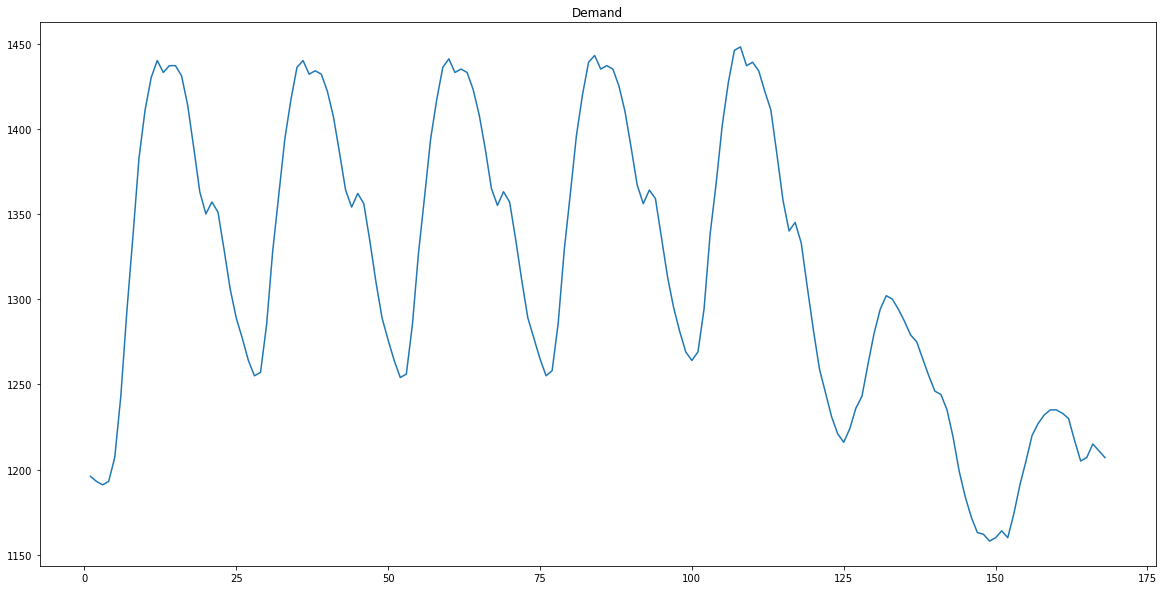

In [5]:
raw_demand = [1196,1193,1191,1193,1207,1243,1293,1337,1383,1411,1430,1440,1433,1437,1437,1431,
              1414,1389,1363,1350,1357,1351,1329,1306,1289,1277,1264,1255,1257,1285,1328,1361,
              1394,1417,1436,1440,1432,1434,1432,1422,1407,1386,1364,1354,1362,1356,1334,1310,
              1289,1276,1264,1254,1256,1285,1327,1360,1394,1417,1436,1441,1433,1435,1433,1423,
              1408,1388,1365,1355,1363,1357,1335,1311,1289,1277,1265,1255,1258,1286,1329,1362,
              1396,1420,1439,1443,1435,1437,1435,1425,1410,1389,1367,1356,1364,1359,1336,1313,
              1295,1281,1269,1264,1269,1294,1338,1368,1402,1427,1446,1448,1437,1439,1434,1422,
              1411,1385,1358,1340,1345,1333,1307,1282,1259,1245,1231,1221,1216,1224,1236,1243,
              1262,1280,1294,1302,1300,1294,1287,1279,1275,1265,1255,1246,1244,1235,1219,1199,
              1184,1172,1163,1162,1158,1160,1164,1160,1174,1191,1205,1220,1227,1232,1235,1235,1233,1230,1217,1205,1207,1215,1211,1207]
nb_periods = len(raw_demand)
print("nb periods = {}".format(nb_periods))

demand = Series(raw_demand, index = range(1, nb_periods+1))

# plot demand
demand.plot(title="Demand")

## Formulate-the-optimization-model

### Set up the optimization model
Set up the prescriptive model using  Mathematical Programming (docplex.mp) modeling package.

In [6]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python version 3.7.9, located at: /opt/conda/envs/Python-3.7-main/bin/python
* docplex is present, version is 2.14.186
* CPLEX library is present, version is 12.10.0.0, located at: /opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages
* pandas is present, version is 1.0.5


Create the model which will contain all the business constraints and objectives.

In [7]:
from docplex.mp.model import Model

ucpm = Model("ucp")

### Define the decision variables

Decision variables are:

- The variable *in_use[u,t]* is 1 if and only if unit _u_ is in use at period _t_.
- The variable *turn_on[u,t]* is 1 if and only if unit _u_ is in switched on at period _t_.
- The variable *turn_off[u,t]* is 1 if unit _u_ is switched off at period _t_.
- The variable *production[u,t]* is a continuous variable representing the production of energy for unit _u_ at period _t_.

In [8]:
units = all_units
# periods range from 1 to nb_periods included
periods = range(1, nb_periods+1)

# in use[u,t] is true iff unit u is in production at period t
in_use = ucpm.binary_var_matrix(keys1=units, keys2=periods, name="in_use")

# true if unit u is turned on at period t
turn_on = ucpm.binary_var_matrix(keys1=units, keys2=periods, name="turn_on")

# true if unit u is switched off at period t
# modeled as a continuous 0-1 variable, more on this later
turn_off = ucpm.continuous_var_matrix(keys1=units, keys2=periods, lb=0, ub=1, name="turn_off")

# production of energy for unit u at period t
production = ucpm.continuous_var_matrix(keys1=units, keys2=periods, name="p")

# at this stage you have defined the decision variables.
ucpm.print_information()

Model: ucp
 - number of variables: 6720
   - binary=3360, integer=0, continuous=3360
 - number of constraints: 0
   - linear=0
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [9]:
# Organize all decision variables in a DataFrame indexed by 'units' and 'periods'
df_decision_vars = DataFrame({'in_use': in_use, 'turn_on': turn_on, 'turn_off': turn_off, 'production': production})
# Set index names
df_decision_vars.index.names=['units', 'periods']

# Display first few rows of 'df_decision_vars' DataFrame
df_decision_vars.head()

in_use          turn_on          turn_off production
units periods                                                              
coal1 1        in_use_coal1_1  turn_on_coal1_1  turn_off_coal1_1  p_coal1_1
      2        in_use_coal1_2  turn_on_coal1_2  turn_off_coal1_2  p_coal1_2
      3        in_use_coal1_3  turn_on_coal1_3  turn_off_coal1_3  p_coal1_3
      4        in_use_coal1_4  turn_on_coal1_4  turn_off_coal1_4  p_coal1_4
      5        in_use_coal1_5  turn_on_coal1_5  turn_off_coal1_5  p_coal1_5

### Express the business constraints

#### Linking in-use status to production

Whenever a unit is in use, the production must be within the unit's minimum and maximum generation.


In [10]:
# Create a join between 'df_decision_vars' and 'df_up' Data Frames based on common index id (ie: 'units')
# In 'df_up', one keeps only relevant columns: 'min_gen' and 'max_gen'
df_join_decision_vars_up = df_decision_vars.join(df_up[['min_gen', 'max_gen']], how='inner')

# Display first few rows of joined Data Frames
df_join_decision_vars_up.head()

in_use          turn_on          turn_off production  \
units periods                                                                 
coal1 1        in_use_coal1_1  turn_on_coal1_1  turn_off_coal1_1  p_coal1_1   
      2        in_use_coal1_2  turn_on_coal1_2  turn_off_coal1_2  p_coal1_2   
      3        in_use_coal1_3  turn_on_coal1_3  turn_off_coal1_3  p_coal1_3   
      4        in_use_coal1_4  turn_on_coal1_4  turn_off_coal1_4  p_coal1_4   
      5        in_use_coal1_5  turn_on_coal1_5  turn_off_coal1_5  p_coal1_5   

               min_gen  max_gen  
units periods                    
coal1 1          100.0      425  
      2          100.0      425  
      3          100.0      425  
      4          100.0      425  
      5          100.0      425

In [11]:
# When in use, the production level is constrained to be between min and max generation.
for item in df_join_decision_vars_up.itertuples(index=False):
    ucpm += (item.production <= item.max_gen * item.in_use)
    ucpm += (item.production >= item.min_gen * item.in_use)

#### Initial state
The solution must take into account the initial state. The initial state of use of a unit is determined by its initial production level.

In [12]:
# Initial state
# If initial production is nonzero, then period #1 is not a turn_on
# else turn_on equals in_use
# Dual logic is implemented for turn_off
for u in units:
    if df_up.initial[u] > 0:
        # if u is already running, not starting up
        ucpm.add_constraint(turn_on[u, 1] == 0)
        # turnoff iff not in use
        ucpm.add_constraint(turn_off[u, 1] + in_use[u, 1] == 1)
    else:
        # turn on at 1 iff in use at 1
        ucpm.add_constraint(turn_on[u, 1] == in_use[u, 1])
        # already off, not switched off at t==1
        ucpm.add_constraint(turn_off[u, 1] == 0)
ucpm.print_information()

Model: ucp
 - number of variables: 6720
   - binary=3360, integer=0, continuous=3360
 - number of constraints: 3380
   - linear=3380
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Ramp-up / ramp-down constraint
Variations of the production level over time in a unit is constrained by a ramp-up / ramp-down process.

Use the *pandas* *groupby* operation to collect all decision variables for each unit in separate series. Then, iterate over units to post constraints enforcing the ramp-up / ramp-down process by setting upper bounds on the variation of the production level for consecutive periods.

In [13]:
# Use groupby operation to process each unit
for unit, r in df_decision_vars.groupby(level='units'):
    u_ramp_up = df_up.ramp_up[unit]
    u_ramp_down = df_up.ramp_down[unit]
    u_initial = df_up.initial[unit]
    # Initial ramp up/down
    # Note that r.production is a Series that can be indexed as an array (ie: first item index = 0)
    ucpm.add_constraint(r.production[0] - u_initial <= u_ramp_up)
    ucpm.add_constraint(u_initial - r.production[0] <= u_ramp_down)
    for (p_curr, p_next) in zip(r.production, r.production[1:]):
        ucpm.add_constraint(p_next - p_curr <= u_ramp_up)
        ucpm.add_constraint(p_curr - p_next <= u_ramp_down)

ucpm.print_information()

Model: ucp
 - number of variables: 6720
   - binary=3360, integer=0, continuous=3360
 - number of constraints: 6740
   - linear=6740
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Turn on / turn off
The following constraints determine when a unit is turned on or off.

Use the same *pandas* *groupby* operation as in the previous constraint to iterate over the sequence of decision variables for each unit.

In [14]:
# Turn_on, turn_off
# Use groupby operation to process each unit
for unit, r in df_decision_vars.groupby(level='units'):
    for (in_use_curr, in_use_next, turn_on_next, turn_off_next) in zip(r.in_use, r.in_use[1:], r.turn_on[1:], r.turn_off[1:]):
        # if unit is off at time t and on at time t+1, then it was turned on at time t+1
        ucpm.add_constraint(in_use_next - in_use_curr <= turn_on_next)

        # if unit is on at time t and time t+1, then it was not turned on at time t+1
        # mdl.add_constraint(in_use_next + in_use_curr + turn_on_next <= 2)

        # if unit is on at time t and off at time t+1, then it was turned off at time t+1
        ucpm.add_constraint(in_use_curr - in_use_next + turn_on_next == turn_off_next)
ucpm.print_information()        

Model: ucp
 - number of variables: 6720
   - binary=3360, integer=0, continuous=3360
 - number of constraints: 10080
   - linear=10080
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Minimum uptime and downtime
When a unit is turned on, it cannot be turned off before a *minimum uptime*. Conversely, when a unit is turned off, it cannot be turned on again before a *minimum downtime*.

Again, let's use the same *pandas* *groupby* operation to implement this constraint for each unit.

In [15]:
# Minimum uptime, downtime
for unit, r in df_decision_vars.groupby(level='units'):
    min_uptime   = df_up.min_uptime[unit]
    min_downtime = df_up.min_downtime[unit]
    # Note that r.turn_on and r.in_use are Series that can be indexed as arrays (ie: first item index = 0)
    for t in range(min_uptime, nb_periods):
        ctname = "min_up_{0!s}_{1}".format(*r.index[t])
        ucpm.add_constraint(ucpm.sum(r.turn_on[(t - min_uptime) + 1:t + 1]) <= r.in_use[t], ctname)

    for t in range(min_downtime, nb_periods):
        ctname = "min_down_{0!s}_{1}".format(*r.index[t])
        ucpm.add_constraint(ucpm.sum(r.turn_off[(t - min_downtime) + 1:t + 1]) <= 1 - r.in_use[t], ctname)


#### Demand constraint
Total production level must be equal to or higher than demand on any period.

This time, the *pandas* operation *groupby* is performed on *"periods"* since you have to iterate over the list of all units for each period.

In [16]:
# Enforcing demand
# use a >= here to be more robust, 
# objective will ensure efficient production
for period, r in df_decision_vars.groupby(level='periods'):
    total_demand = demand[period]
    ctname = "ct_meet_demand_%d" % period
    ucpm.add_constraint(ucpm.sum(r.production) >= total_demand, ctname) 

### Express the objective

Operating the different units incurs different costs: fixed cost, variable cost, startup cost, co2 cost.

In a first step, define the objective as a non-weighted sum of all these costs.

The following *pandas* *join* operation groups all the data to calculate the objective in a single DataFrame.

In [17]:
# Create a join between 'df_decision_vars' and 'df_up' Data Frames based on common index ids (ie: 'units')
# In 'df_up', one keeps only relevant columns: 'fixed_cost', 'variable_cost', 'start_cost' and 'co2_cost'
df_join_obj = df_decision_vars.join(
    df_up[['fixed_cost', 'variable_cost', 'start_cost', 'co2_cost']], how='inner')

# Display first few rows of joined Data Frame
df_join_obj.head()

in_use          turn_on          turn_off production  \
units periods                                                                 
coal1 1        in_use_coal1_1  turn_on_coal1_1  turn_off_coal1_1  p_coal1_1   
      2        in_use_coal1_2  turn_on_coal1_2  turn_off_coal1_2  p_coal1_2   
      3        in_use_coal1_3  turn_on_coal1_3  turn_off_coal1_3  p_coal1_3   
      4        in_use_coal1_4  turn_on_coal1_4  turn_off_coal1_4  p_coal1_4   
      5        in_use_coal1_5  turn_on_coal1_5  turn_off_coal1_5  p_coal1_5   

               fixed_cost  variable_cost  start_cost  co2_cost  
units periods                                                   
coal1 1            208.61         22.536        5000        30  
      2            208.61         22.536        5000        30  
      3            208.61         22.536        5000        30  
      4            208.61         22.536        5000        30  
      5            208.61         22.536        5000        30

In [18]:
# objective
total_fixed_cost = ucpm.sum(df_join_obj.in_use * df_join_obj.fixed_cost)
total_variable_cost = ucpm.sum(df_join_obj.production * df_join_obj.variable_cost)
total_startup_cost = ucpm.sum(df_join_obj.turn_on * df_join_obj.start_cost)
total_co2_cost = ucpm.sum(df_join_obj.production * df_join_obj.co2_cost)
total_economic_cost = total_fixed_cost + total_variable_cost + total_startup_cost

total_nb_used = ucpm.sum(df_decision_vars.in_use)
total_nb_starts = ucpm.sum(df_decision_vars.turn_on)

# store expression kpis to retrieve them later.
ucpm.add_kpi(total_fixed_cost   , "Total Fixed Cost")
ucpm.add_kpi(total_variable_cost, "Total Variable Cost")
ucpm.add_kpi(total_startup_cost , "Total Startup Cost")
ucpm.add_kpi(total_economic_cost, "Total Economic Cost")
ucpm.add_kpi(total_co2_cost     , "Total CO2 Cost")
ucpm.add_kpi(total_nb_used, "Total #used")
ucpm.add_kpi(total_nb_starts, "Total #starts")

# minimize sum of all costs
ucpm.minimize(total_fixed_cost + total_variable_cost + total_startup_cost + total_co2_cost)

## Solve with Decision Optimization

Depending on the size of the problem, the solve stage might fail and require the Commercial Edition of CPLEX engines, which is included in the premium environments in Watson Studio.

In [19]:
ucpm.print_information()

Model: ucp
 - number of variables: 6720
   - binary=3360, integer=0, continuous=3360
 - number of constraints: 13511
   - linear=13511
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP


In [20]:
assert ucpm.solve(), "!!! Solve of the model fails"

In [21]:
ucpm.report()

* model ucp solved with objective = 12356315.608
*  KPI: Total Fixed Cost    = 129033.981
*  KPI: Total Variable Cost = 7608371.627
*  KPI: Total Startup Cost  = 7455.000
*  KPI: Total Economic Cost = 7744860.608
*  KPI: Total CO2 Cost      = 4611455.000
*  KPI: Total #used         = 1105.000
*  KPI: Total #starts       = 9.000


### Analyze the solution

Now store the results in a new *pandas* DataFrame.

For convenience, the different figures are organized into pivot tables with *periods* as row index and *units* as columns. The *pandas* *unstack* operation does this for you.

In [22]:
df_prods = df_decision_vars.production.apply(lambda v: max(0, v.solution_value)).unstack(level='units')
df_used = df_decision_vars.in_use.apply(lambda v: max(0, v.solution_value)).unstack(level='units')
df_started = df_decision_vars.turn_on.apply(lambda v: max(0, v.solution_value)).unstack(level='units')

# Display the first few rows of the pivoted 'production' data
df_prods.head()

units,coal1,coal2,diesel1,diesel2,diesel3,diesel4,gas1,gas2,gas3,gas4
periods,,,,,,,,,,
1,425.0,161.6,90.0,87.0,0.0,0.0,109.4,0.0,165.0,158.0
2,425.0,190.0,90.0,87.0,0.0,0.0,78.0,0.0,165.0,158.0
3,425.0,266.0,90.0,87.0,0.0,0.0,0.0,0.0,165.0,158.0
4,425.0,268.0,90.0,87.0,0.0,0.0,0.0,0.0,165.0,158.0
5,425.0,282.0,90.0,87.0,0.0,0.0,0.0,0.0,165.0,158.0


####  Production per Unit 

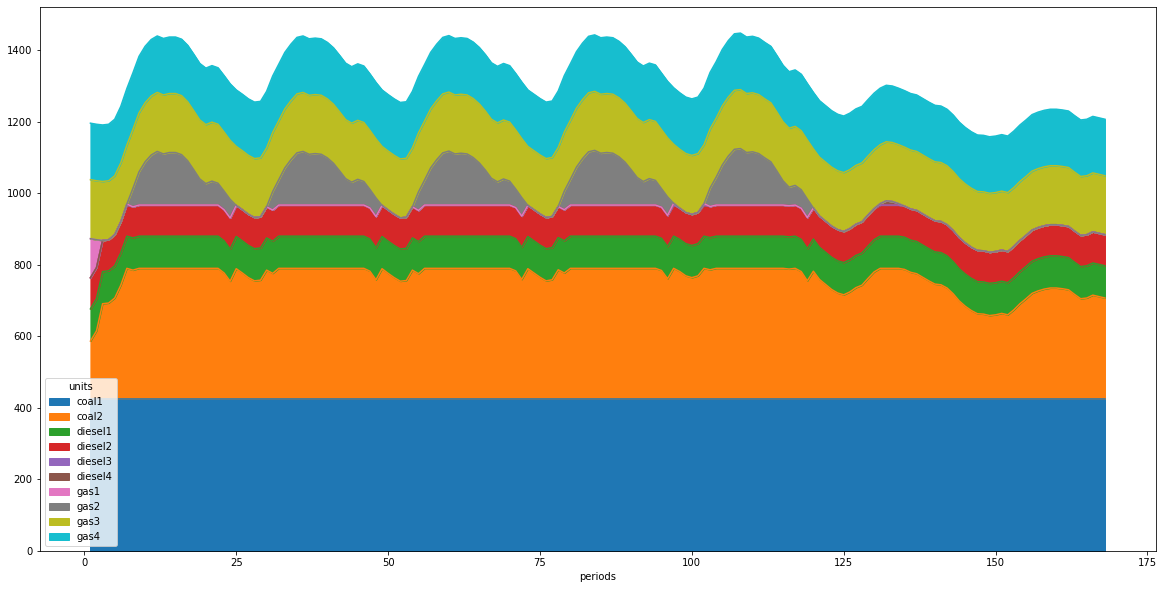

In [23]:
df_prods.plot.area()

#### Reserve per Unit

From these raw DataFrame results, you can compute _derived_ results.
For example, for a given unit and period, the _reserve_ r(u,t) is defined as
the unit's maximum generation minus the current production.

In [24]:
df_spins = DataFrame(df_up.max_gen.to_dict(), index=periods) - df_prods

# Display the first few rows of the 'df_spins' Data Frame, representing the reserve for each unit, over time
df_spins.head()

,coal1,coal2,diesel1,diesel2,diesel3,diesel4,gas1,gas2,gas3,gas4
1,0.0,203.4,0.0,0.0,20.0,12.0,110.6,210.0,0.0,0.0
2,0.0,175.0,0.0,0.0,20.0,12.0,142.0,210.0,0.0,0.0
3,0.0,99.0,0.0,0.0,20.0,12.0,220.0,210.0,0.0,0.0
4,0.0,97.0,0.0,0.0,20.0,12.0,220.0,210.0,0.0,0.0
5,0.0,83.0,0.0,0.0,20.0,12.0,220.0,210.0,0.0,0.0


Now plot the evolution of the reserve for the *"coal2"* unit:

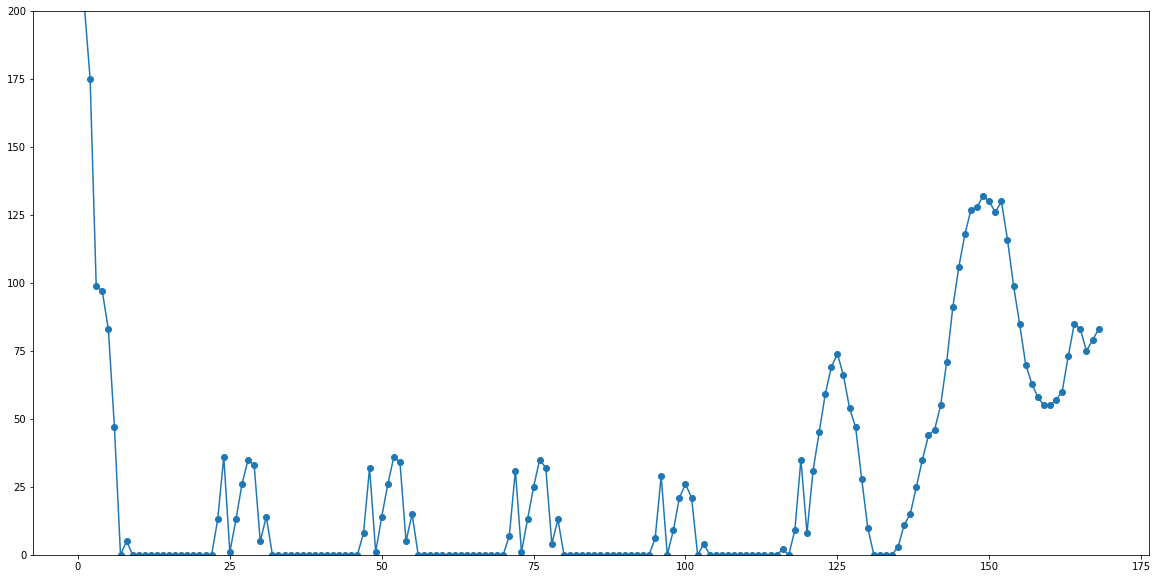

In [25]:
df_spins.coal2.plot(style='o-', ylim=[0,200])

Next, sum all unit reserves to compute the _global_ spinning reserve.
Sum all columns of the DataFrame to get an aggregated time series. Use the *pandas* **sum** method
with axis=1 (for rows).

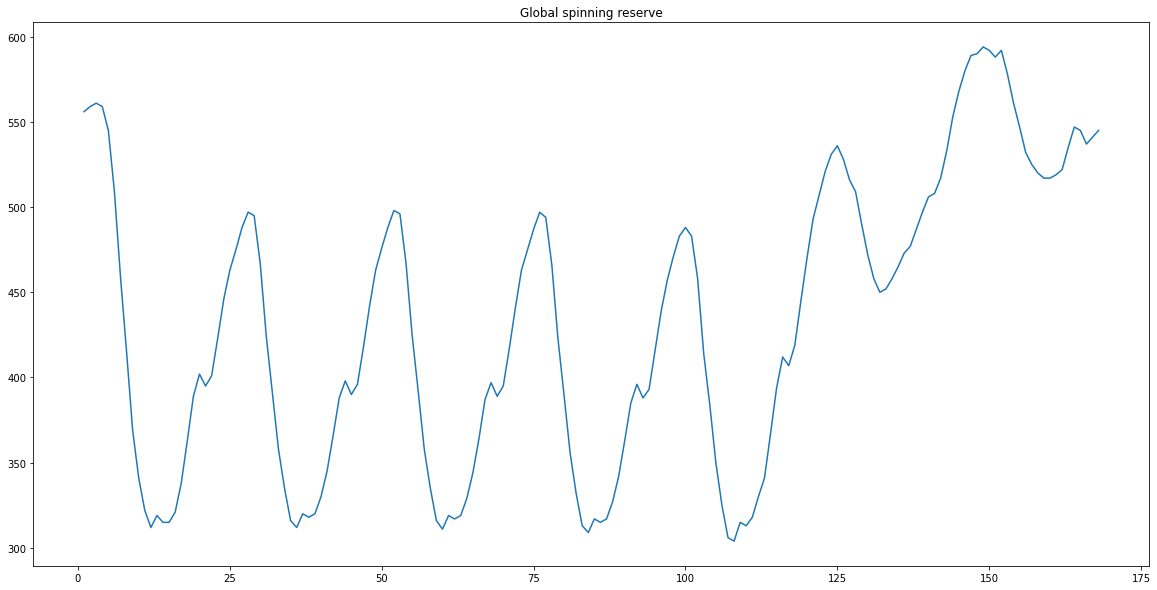

In [26]:
global_spin = df_spins.sum(axis=1)
global_spin.plot(title="Global spinning reserve")

#### Number of plants online by period

The total number of plants online at each period t is the sum of in_use variables for all units at this period.
Again, use the *pandas* sum with axis=1 (for rows) to sum over all units.

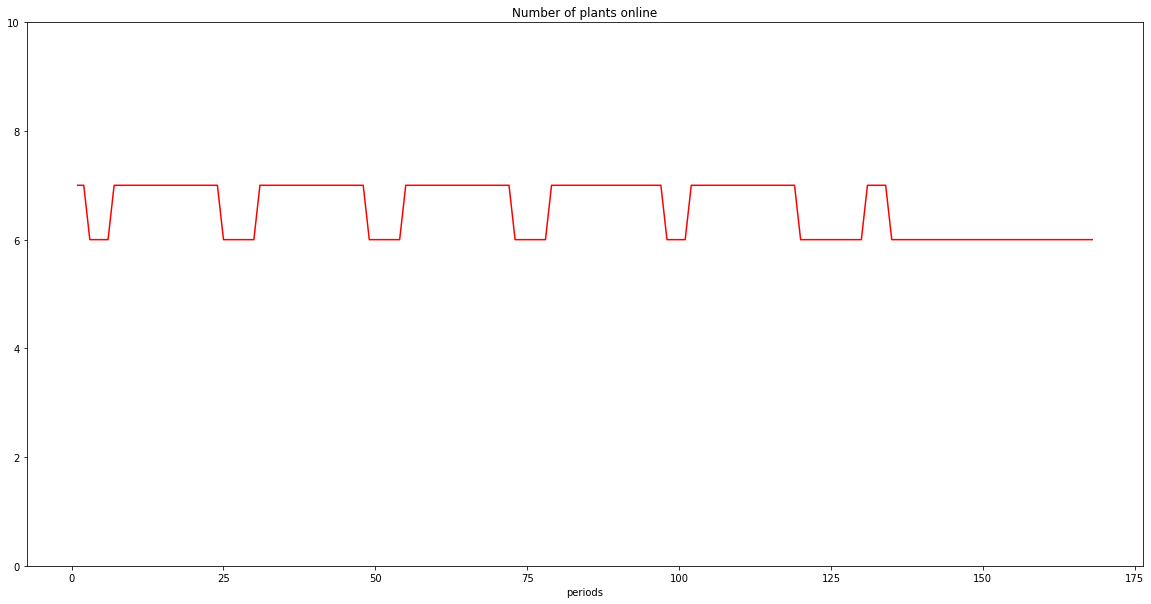

In [27]:
df_used.sum(axis=1).plot(title="Number of plants online", kind='line', style="r-", ylim=[0, len(units)])

#### Costs by period

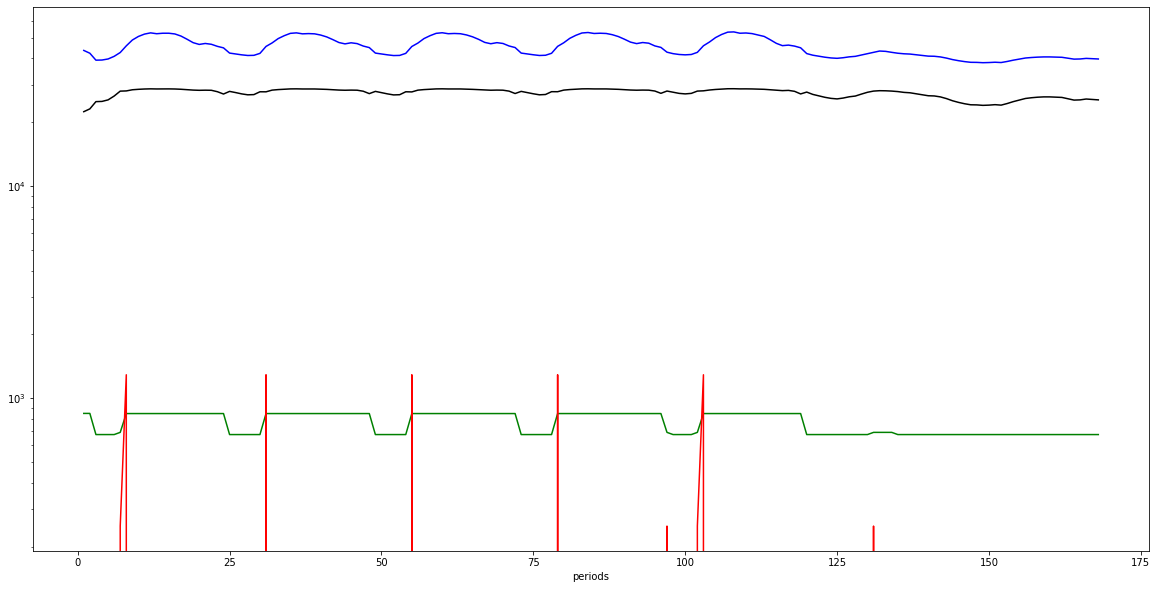

In [28]:
# extract unit cost data
all_costs = ["fixed_cost", "variable_cost", "start_cost", "co2_cost"]
df_costs = df_up[all_costs]

running_cost = df_used * df_costs.fixed_cost
startup_cost = df_started * df_costs.start_cost
variable_cost = df_prods * df_costs.variable_cost
co2_cost = df_prods * df_costs.co2_cost
total_cost = running_cost + startup_cost + variable_cost + co2_cost

running_cost.sum(axis=1).plot(style='g')
startup_cost.sum(axis=1).plot(style='r')
variable_cost.sum(axis=1).plot(style='b',logy=True)
co2_cost.sum(axis=1).plot(style='k')

#### Cost breakdown by unit and by energy

Text(0.5, 1.0, 'total cost by energy type')

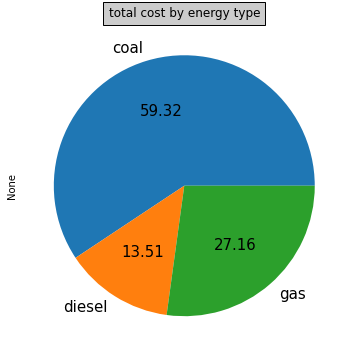

In [29]:
# Calculate sum by column (by default, axis = 0) to get total cost for each unit
cost_by_unit = total_cost.sum()

# Create a dictionary storing energy type for each unit, from the corresponding pandas Series
unit_energies = df_up.energy.to_dict()

# Group cost by unit type and plot total cost by energy type in a pie chart
gb = cost_by_unit.groupby(unit_energies)
# gb.sum().plot(kind='pie')
gb.sum().plot.pie(figsize=(6, 6),autopct='%.2f',fontsize=15)

plt.title('total cost by energy type', bbox={'facecolor':'0.8', 'pad':5})

## Perform what-if analysis

Apart from solving one instance and getting the optimal solution, Decision Optimization allows you to easily perform what-if analysis, running different **scenarios** with different data and/or models.
 
### Example of arbitration between ecological and economic cost

Economic cost and ecological (CO<sub>2</sub>) cost are competing objectives: to reduce the economic cost, you need to use a more dirty generator which produces more CO2.

In the previous section, you minimized the raw sum of economic cost and CO<sub>2</sub> cost, without weights.

#### Optimal solution with respect to the ecological cost

But how much further could you reduce CO<sub>2</sub> emissions, if economic cost was not important? 
To find this out, solve again with CO<sub>2</sub> cost as the only objective.


In [30]:
# first retrieve the co2 and economic kpis
co2_kpi = ucpm.kpi_by_name("co2") # does a name matching
eco_kpi = ucpm.kpi_by_name("eco")
prev_co2_cost = co2_kpi.compute()
prev_eco_cost = eco_kpi.compute()
print("* current CO2 cost is: {}".format(prev_co2_cost))
print("* current $$$ cost is: {}".format(prev_eco_cost))
# now set the objective
old_objective = ucpm.objective_expr # save it
ucpm.minimize(co2_kpi.as_expression())

* current CO2 cost is: 4611455.0
* current $$$ cost is: 7744860.607999987


In [31]:
assert ucpm.solve(), "Solve failed"

In [32]:
min_co2_cost = ucpm.objective_value
min_co2_eco_cost = eco_kpi.compute()
print("* absolute minimum for CO2 cost is {}".format(min_co2_cost))
print("* at this point $$$ cost is {}".format(min_co2_eco_cost))

* absolute minimum for CO2 cost is 2956337.0
* at this point $$$ cost is 10775212.795400122


As expected, you get a significantly lower CO<sub>2</sub> cost when minimized alone, at the price of a higher economic cost.

#### Optimal solution with respect to the economic cost

You can do a similar analysis for economic cost to estimate the absolute minimum of
the economic cost, regardless of CO<sub>2</sub> cost.

In [33]:
# minimize only economic cost
ucpm.minimize(eco_kpi.as_expression())

In [34]:
assert ucpm.solve(), "Solve failed"

In [35]:
min_eco_cost = ucpm.objective_value
min_eco_co2_cost = co2_kpi.compute()
print("* absolute minimum for $$$ cost is {}".format(min_eco_cost))
print("* at this point CO2 cost is {}".format(min_eco_co2_cost))

* absolute minimum for $$$ cost is 7646969.15039999
* at this point CO2 cost is 4720894.0


Again, the absolute minimum for economic cost is lower than the figure you obtained in the original model where you minimized the _sum_ of economic and CO<sub>2</sub> costs, but here the CO<sub>2</sub> is significantly increased.

#### Pareto optimum

But what happens in between these two extreme points?

To investigate this, divide the interval of CO<sub>2</sub> cost values in smaller intervals, add an upper limit on CO<sub>2</sub>,
and minimize economic cost with this constraint. This will give you a Pareto optimal point with at most this CO<sub>2</sub> value.

To avoid adding many constraints, add only one constraint with an extra variable, and change only the upper bound
of this CO<sub>2</sub> limit variable between successive solves.

Then iterate (with a fixed number of iterations) and collect the cost values. 

In [36]:
# add extra variable
co2_limit = ucpm.continuous_var(lb=0)
# add a named constraint which limits total co2 cost to this variable:
max_co2_ctname = "ct_max_co2"
co2_ct = ucpm.add_constraint(co2_kpi.as_expression() <= co2_limit, max_co2_ctname)     

In [37]:
co2min = min_co2_cost
co2max = min_eco_co2_cost
def explore_ucp(nb_iters, eps=1e-5):

    step = (co2max-co2min)/float(nb_iters)
    co2_ubs = [co2min + k * step for k in range(nb_iters+1)]

    # ensure eco minimized
    ucpm.minimize(eco_kpi.as_expression())
    all_co2s = []
    all_ecos = []
    for k in range(nb_iters+1):
        co2_ub = co2min + k * step
        print(" iteration #{0} co2_ub={1}".format(k, co2_ub))
        co2_limit.ub = co2_ub + eps
        assert ucpm.solve() is not None, "Solve failed"
        cur_co2 = co2_kpi.compute()
        cur_eco = eco_kpi.compute()
        all_co2s.append(cur_co2)
        all_ecos.append(cur_eco)
    return all_co2s, all_ecos

In [38]:
#explore the co2/eco frontier in 50 points
co2s, ecos = explore_ucp(nb_iters=50)

 iteration #0 co2_ub=2956337.0
 iteration #1 co2_ub=2991628.14
 iteration #2 co2_ub=3026919.28
 iteration #3 co2_ub=3062210.42
 iteration #4 co2_ub=3097501.56
 iteration #5 co2_ub=3132792.7
 iteration #6 co2_ub=3168083.84
 iteration #7 co2_ub=3203374.98
 iteration #8 co2_ub=3238666.12
 iteration #9 co2_ub=3273957.26
 iteration #10 co2_ub=3309248.4
 iteration #11 co2_ub=3344539.54
 iteration #12 co2_ub=3379830.68
 iteration #13 co2_ub=3415121.82
 iteration #14 co2_ub=3450412.96
 iteration #15 co2_ub=3485704.1
 iteration #16 co2_ub=3520995.24
 iteration #17 co2_ub=3556286.38
 iteration #18 co2_ub=3591577.52
 iteration #19 co2_ub=3626868.66
 iteration #20 co2_ub=3662159.8
 iteration #21 co2_ub=3697450.94
 iteration #22 co2_ub=3732742.08
 iteration #23 co2_ub=3768033.2199999997
 iteration #24 co2_ub=3803324.36
 iteration #25 co2_ub=3838615.5
 iteration #26 co2_ub=3873906.64
 iteration #27 co2_ub=3909197.7800000003
 iteration #28 co2_ub=3944488.92
 iteration #29 co2_ub=3979780.06
 iteration

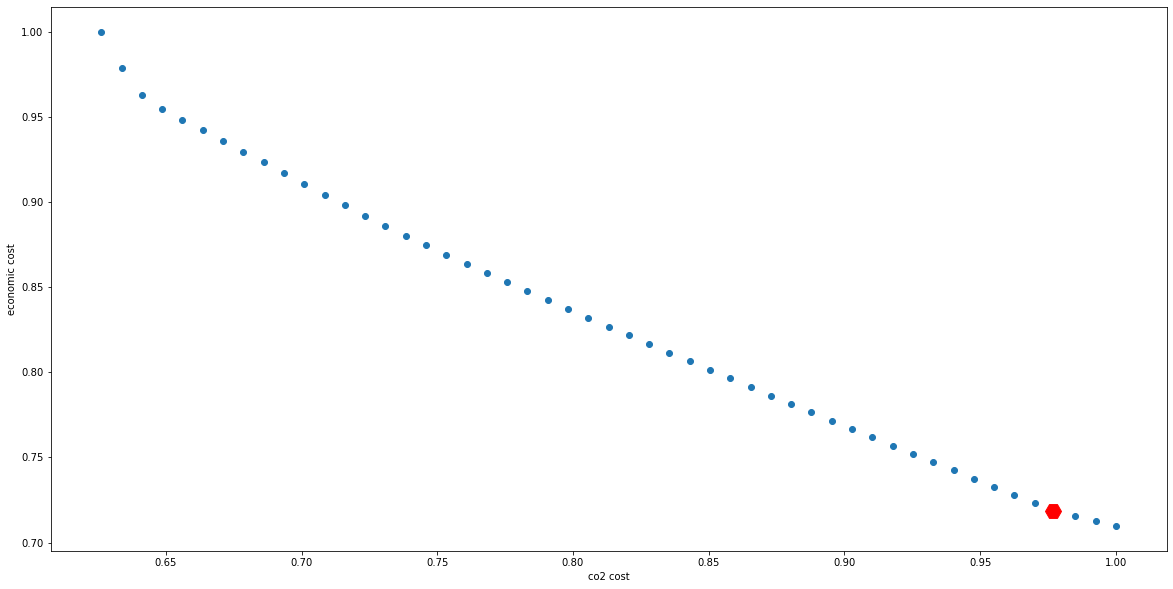

In [39]:
# normalize all values by dividing by their maximum
eco_max = min_co2_eco_cost
nxs = [c / co2max for c in co2s]
nys = [e / eco_max for e in ecos]
# plot a scatter chart of x=co2, y=costs
plt.scatter(nxs, nys)
# plot as one point
plt.plot(prev_co2_cost/co2max, prev_eco_cost/eco_max, "rH", markersize=16)
plt.xlabel("co2 cost")
plt.ylabel("economic cost")
plt.show()

This figure demonstrates that the result obtained in the initial model clearly favored
economic cost over CO<sub>2</sub> cost: CO<sub>2</sub> cost is well above 95% of its maximum value.

## Summary

You have learned how to set up, formulate and solve an optimization model using Decision Optimization in Watson Studio.

#### References
* <a href="https://rawgit.com/IBMDecisionOptimization/docplex-doc/master/docs/index.html" target="_blank" rel="noopener noreferrer">Decision Optimization CPLEX Modeling for Python documentation</a>
* <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/welcome-main.html" target="_blank" rel="noopener noreferrer">Cloud Pack for Data as a Service documentation</a>


<hr>
Copyright © 2017-2021. This notebook and its source code are released under the terms of the MIT License.